## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
#import scipy as sp
#import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [2]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need
train_data.describe(include='all')

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,42364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,62970.972413,NaN,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,NaN,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,NaN,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,NaN,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,NaN,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,NaN,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000


In [3]:
df_contr = train_data.loc[train_data['Promotion'] == 'No']
df_exper = train_data.loc[train_data['Promotion'] == 'Yes']

X = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y = train_data['purchase']

X_contr = df_contr[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_contr = df_contr['purchase']

X_exper = df_exper[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_exper = df_exper['purchase']

param_grid = {
    #'n_estimators': [100, 200, 500],
    #'max_depth': [10, 20, None],
    #'min_samples_split': [2, 5],
    #'min_samples_leaf': [1, 2],
    'max_features': [None],
    'bootstrap': [True, False],
    'class_weight': ['balanced'],
    #'random_state' : [39, 40, 41, 60, 61] #(0.017791270477717953, 9.100000000000001)
    'random_state' : [43, 44, 45] # (0.01792539719088188, 9.400000000000006)
    #'random_state' : [46, 47, 48] # (0.01768004185432874, 8.800000000000004)
    #'random_state' : [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]#(0.01768004185432874, 8.800000000000004)
}


model_contr = RandomForestClassifier()
grid_search_contr = GridSearchCV(estimator=model_contr, param_grid=param_grid, n_jobs=6, scoring='f1')
#grid_search_contr = RandomForestClassifier(max_features=None, class_weight='balanced')
grid_search_contr.fit(X_contr, y_contr)


model_exper = RandomForestClassifier()
grid_search_exper = GridSearchCV(estimator=model_exper, param_grid=param_grid, n_jobs=6, scoring='f1')
#grid_search_exper = RandomForestClassifier(max_features=None, class_weight='balanced')
grid_search_exper.fit(X_exper, y_exper)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced'], 'max_features': [None],
                         'random_state': [43, 44, 45]},
             scoring='f1')

In [4]:

test_data = pd.read_csv('./Test.csv')
X_test = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
df_pred = test_data[['ID', 'Promotion', 'purchase']].copy()
#df_pred['exper_pred'] = model_exper.predict_proba(X_test)[:, 1]
#df_pred['contr_pred'] = model_contr.predict_proba(X_test)[:, 1]
df_pred['exper_pred'] = grid_search_exper.predict_proba(X_test)[:, 1]
df_pred['contr_pred'] = grid_search_contr.predict_proba(X_test)[:, 1]
df_pred['uplift'] = df_pred['exper_pred'] - df_pred['contr_pred']
df_pred.head()




,ID,Promotion,purchase,exper_pred,contr_pred,uplift
0,2,No,0,0.0,0.0,0.0
1,6,Yes,0,0.0,0.0,0.0
2,7,Yes,0,0.0,0.0,0.0
3,10,No,0,0.0,0.0,0.0
4,12,No,0,0.0,0.0,0.0


In [5]:
#q = df_pred['uplift'].quantile()
#df_result = df_pred.loc[df_pred['uplift'] >= q]
#df_pred['send_promo'] = df_pred['uplift'].apply(lambda x: 'Yes' if x > 0 else 'No')
#df_pred['send_promo'].values
#| ((df_pred['exper_pred'] > 0) & (df_pred['contr_pred'] > 0))
data = df_pred[(df_pred['uplift'] > 0)]
score(data)


(0.01792539719088188, 9.400000000000006)

In [6]:
data.shape[0]

834

Random forest return the model that have not good result.
Try LogisticRegression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search_log_exper = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=6)
grid_search_log_exper.fit(X_exper, y_exper)

grid_search_log_control = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=6)
grid_search_log_control.fit(X_contr, y_contr)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=6,
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [8]:
df_log_pred = test_data[['ID', 'Promotion', 'purchase']].copy()
#df_pred['exper_pred'] = model_exper.predict_proba(X_test)[:, 1]
#df_pred['contr_pred'] = model_contr.predict_proba(X_test)[:, 1]
df_log_pred['exper_pred'] = grid_search_log_exper.predict_proba(X_test)[:, 1]
df_log_pred['contr_pred'] = grid_search_log_control.predict_proba(X_test)[:, 1]
df_log_pred['uplift'] = df_log_pred['exper_pred'] - df_log_pred['contr_pred']
df_log_pred.head()

,ID,Promotion,purchase,exper_pred,contr_pred,uplift
0,2,No,0,0.008252,0.008250,0.000002
1,6,Yes,0,0.018178,0.008281,0.009896
2,7,Yes,0,0.024923,0.006971,0.017952
3,10,No,0,0.023112,0.007036,0.016076
4,12,No,0,0.017604,0.007848,0.009756


In [9]:
# Try with default quantile 50%
q_log = df_log_pred['uplift'].quantile()
data_log = df_log_pred[(df_log_pred['uplift'] > q_log)]
score(data_log)

(0.016593694342654175, 167.0)

In [16]:
# Try with quantile in range 46 to 86%
lst_p_cutoff = []
lst_irr = []
lst_nir = []
lst_p_select = []
for p in range(46,86):
    q_log = df_log_pred['uplift'].quantile(p/100)
    data_log = df_log_pred[(df_log_pred['uplift'] > q_log)]
    lst_p_cutoff.append(p)
    irr, nir = score(data_log)
    lst_irr.append(irr)
    lst_nir.append(nir)
    lst_p_select.append(100-p)
df_result = pd.DataFrame()
df_result['p_cutoff'] = lst_p_cutoff
df_result['IRR'] = lst_irr
df_result['NIR'] = lst_nir
df_result['p_select'] = lst_p_select
df_result

,p_cutoff,IRR,NIR,p_select
0,46,0.015872,100.55,54
1,47,0.015806,91.60,53
2,48,0.015841,93.25,52
3,49,0.015944,98.65,51
4,50,0.016594,167.00,50
5,51,0.016747,178.80,49
6,52,0.017048,207.60,48
7,53,0.017025,200.00,47
8,54,0.017204,212.10,46
9,55,0.016805,166.75,45


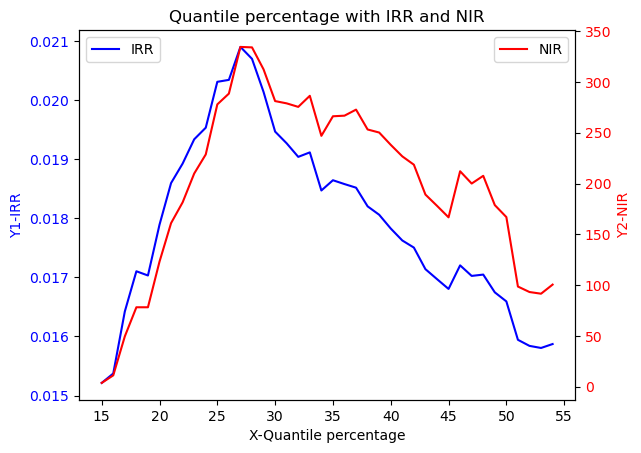

In [17]:
fig, ax1 = plt.subplots()

sns.lineplot(x='p_select', y='IRR', data=df_result, ax=ax1, label='IRR', color='b')

ax1.set_xlabel('X-Quantile percentage')
ax1.set_ylabel('Y1-IRR', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
sns.lineplot(x='p_select', y='NIR', data=df_result, ax=ax2, label='NIR', color='r')

ax2.set_ylabel('Y2-NIR', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Quantile percentage with IRR and NIR')

plt.show()


In [12]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''

    df_log_pred['exper_pred'] = grid_search_log_exper.predict_proba(df)[:, 1]
    df_log_pred['contr_pred'] = grid_search_log_control.predict_proba(df)[:, 1]
    df_log_pred['uplift'] = df_log_pred['exper_pred'] - df_log_pred['contr_pred']
    p = .73
    q = df_log_pred['uplift'].quantile(p)
    promotion = df_log_pred['uplift'].apply(lambda x: 'Yes' if x > q else 'No').values

    #promotion = np.random.choice(['Yes', 'No'], size=test_data.shape[0], p=[0.5, 0.5])
    #promotion = np.full(test_data.shape[0], 'Yes')
    
    return promotion

In [13]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0209.

Your nir with this strategy is 334.45.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.020901239812229345, 334.45000000000005)

In [14]:

df_log_pred[(df_log_pred['uplift'] > 0)].shape[0]

41496